# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

In [3]:
folder_list25 = []
folder_list5 = []
for i in folder_list:
    if i[-3] == '.':
        folder_list25.append(i)
    else:
        folder_list5.append(i)

In [4]:
folder_list25

['FM_2.4_2.5%',
 'FM_2.6_2.5%',
 'FM_2.8_2.5%',
 'FM_3.0_2.5%',
 'FM_3.2_2.5%',
 'FM_3.4_2.5%',
 'FM_3.61_2.5%']

In [5]:
for one_folder in folder_list25:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    # eveloped_one_folder : FM_classnum
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    # dataset folder path
    data_list = os.listdir(join_folder_path)
    # data list in folder
    
    ## train / test = 8:2
    test_list = random.sample(data_list, int(len(data_list) * 0.2))

    for one_data in data_list:
        
        join_data_path = os.path.join(join_folder_path, one_data)
        # each data path
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = np.reshape(img, (512,512,1)) # one channel

        # train
        if not one_data in test_list:
            # if data is not in test_list which is sampled before, add data in x_train, and class in y_train
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
FM_2.6_2.5%
FM_2.8_2.5%
FM_3.0_2.5%
FM_3.2_2.5%
FM_3.4_2.5%
FM_3.61_2.5%
(7689, 512, 512, 1)
(7689,)
(1920, 512, 512, 1)
(1920,)


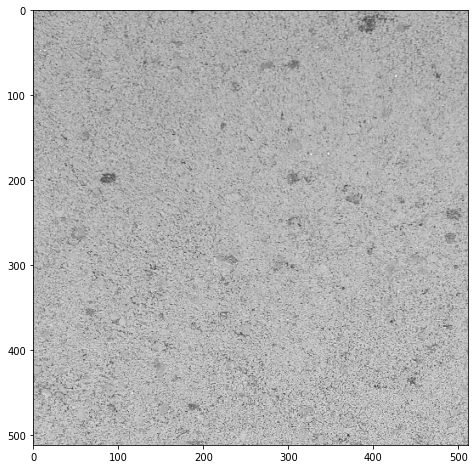

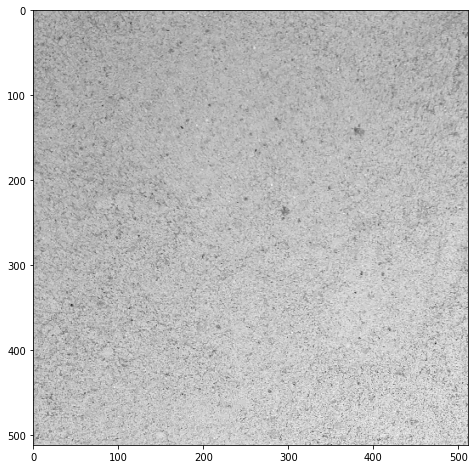

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[1].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [7]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [8]:
import keras

from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Deep Learning Model

In [9]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(inputs)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same",kernel_initializer="glorot_normal")(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# FC
x = Flatten()(x)
x = Dense(128, activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = BatchNormalization()(x)
x = Dense(64, activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = BatchNormalization()(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

#model.summary()
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image("model_plot.png")

Instructions for updating:
Colocations handled automatically by placer.


/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512, 512, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 512, 128)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 128)     512       
__________

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train_onehot,y_val_onehot = train_test_split(x_train,y_train_onehot, test_size = 0.1, shuffle = True, random_state = 42)

In [12]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 20, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/2.5percent2000--{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint_5epoch = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1, period = 50)

## Learning

In [13]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.000001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=2000, batch_size=2,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [checkpoint_5epoch])

# plot loss & val_loss
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
#plt.xticks(np.arange(0,50,1))
plt.legend(loc="upper right");

Instructions for updating:
Use tf.cast instead.
Train on 6920 samples, validate on 769 samples
Epoch 1/2000
6920/6920 [==============================] - 302s 44ms/step - loss: 1.9459 - acc: 0.1496 - val_loss: 13.9880 - val_acc: 0.1287
Epoch 2/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9458 - acc: 0.1571 - val_loss: 13.6768 - val_acc: 0.1495
Epoch 3/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9457 - acc: 0.1577 - val_loss: 13.8584 - val_acc: 0.1378
Epoch 4/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9456 - acc: 0.1577 - val_loss: 13.8607 - val_acc: 0.1391
Epoch 5/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9455 - acc: 0.1577 - val_loss: 13.5941 - val_acc: 0.1534
Epoch 6/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9454 - acc: 0.1577 - val_loss: 13.8027 - val_acc: 0.1417
Epoch 7/2000
6920/6920 [==============================] - 288s 42

Epoch 56/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9422 - acc: 0.1577 - val_loss: 13.5989 - val_acc: 0.1534
Epoch 57/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9422 - acc: 0.1577 - val_loss: 13.8393 - val_acc: 0.1404
Epoch 58/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9421 - acc: 0.1577 - val_loss: 14.1530 - val_acc: 0.1196
Epoch 59/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9421 - acc: 0.1577 - val_loss: 13.8128 - val_acc: 0.1417
Epoch 60/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9420 - acc: 0.1577 - val_loss: 13.8712 - val_acc: 0.1365
Epoch 61/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9420 - acc: 0.1577 - val_loss: 14.0723 - val_acc: 0.1248
Epoch 62/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9420 - acc: 0.1577 - val_loss: 14.0860 - val_acc: 0.1248
Epoch 63/2000

Epoch 113/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9407 - acc: 0.1577 - val_loss: 14.0143 - val_acc: 0.1300
Epoch 114/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9407 - acc: 0.1577 - val_loss: 13.8995 - val_acc: 0.1352
Epoch 115/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9407 - acc: 0.1577 - val_loss: 13.6133 - val_acc: 0.1508
Epoch 116/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9406 - acc: 0.1577 - val_loss: 13.9799 - val_acc: 0.1326
Epoch 117/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9406 - acc: 0.1577 - val_loss: 14.2320 - val_acc: 0.1170
Epoch 118/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9406 - acc: 0.1577 - val_loss: 13.8913 - val_acc: 0.1352
Epoch 119/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9406 - acc: 0.1577 - val_loss: 13.9069 - val_acc: 0.1352
Epoch 

6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 13.9779 - val_acc: 0.1326
Epoch 170/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 14.0651 - val_acc: 0.1248
Epoch 171/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 13.9442 - val_acc: 0.1313
Epoch 172/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 13.9073 - val_acc: 0.1365
Epoch 173/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 13.9767 - val_acc: 0.1300
Epoch 174/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 13.8945 - val_acc: 0.1352
Epoch 175/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9402 - acc: 0.1577 - val_loss: 14.1010 - val_acc: 0.1209
Epoch 176/2000
6920/6

6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.8964 - val_acc: 0.1378
Epoch 226/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.9715 - val_acc: 0.1313
Epoch 227/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.9071 - val_acc: 0.1365
Epoch 228/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.9915 - val_acc: 0.1300
Epoch 229/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.7293 - val_acc: 0.1443
Epoch 230/2000
6920/6920 [==============================] - 289s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.5798 - val_acc: 0.1573
Epoch 231/2000
6920/6920 [==============================] - 288s 42ms/step - loss: 1.9401 - acc: 0.1577 - val_loss: 13.7286 - val_acc: 0.1443
Epoch 232/2000
6920/6

KeyboardInterrupt: 

## Predict

In [ ]:
pred_y = parallel_model.predict(x_test)


In [ ]:
y_test_onehot

In [ ]:
pred_y = np.argmax(pred_y,axis=1 )
real_y = np.argmax(y_test_onehot,axis=1)

print(pred_y)
print(real_y)

In [ ]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]:
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1:
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

In [ ]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

In [ ]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [ ]:
model.save("2.5%2000model")